In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

from bs4 import BeautifulSoup
import requests

import torch
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import numpy as np

from tqdm import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Parsing & Web Scraping

In [2]:
friends = [
'Rachel Greene',
'Monica Geller',
'Chandler Bing',
'Joey Tribbiani',
'Ross Geller',
'Phoebe Buffay'
]

source_train = ['FRIENDS/train/Rachel/', 'FRIENDS/train/Monica/', 'FRIENDS/train/Chandler/',
              'FRIENDS/train/Joey/', 'FRIENDS/train/Ross/', 'FRIENDS/train/Phoebe/']

source_test = 'FRIENDS/test/'

options = webdriver.FirefoxOptions()
options.add_argument('--headless')
driver = webdriver.Firefox(options=options)
url = "https://friends.fandom.com/wiki/Friends_Wiki"

driver.get(url)
print('Opening link...')

assert "Friends" in driver.title

# open page of each friend and download thier photo
for friend_num, friend in enumerate(friends):
    span = driver.find_element_by_class_name('wds-global-navigation__search-toggle-text')
    span.click()
    print('Clicking to span..')

    inp = driver.find_element_by_class_name('wds-global-navigation__search-input')
    inp.send_keys(friend)
    inp.send_keys(Keys.RETURN);
    print('Moving to link:', driver.current_url)
    time.sleep(2)
    driver.get(driver.current_url)

    print('Moving to another link:', driver.current_url)
    link = driver.find_element_by_class_name('unified-search__result__title')
    link.click()
    driver.get(driver.current_url)
    
    print('Downloading images of', friend)
    
    content = driver.page_source

    soup = BeautifulSoup(content, 'lxml')

    image_links = soup.findAll('img')
    image_links_list = []
    
    for link in image_links:
        if 'data-src' in str(link):
            image_links_list.append(link['data-src'])
        
    image_links_list = np.unique(image_links_list)

    for num, link in enumerate(image_links_list):
            if num % 5 ==0:
                print('Image number -', num)
            p = requests.get(link)
            
            # every fifth photo set to test directory
            if num%5!=0:
                out = open(source_train[friend_num] +str(num) + 'jpg', 'wb')
            else:
                out = open(source_test + str(num), 'wb')
                
            out.write(p.content)
            out.close()
    driver.get(url)

Opening link...
Clicking to span..
Moving to link: https://friends.fandom.com/wiki/Friends_Wiki
Moving to another link: https://friends.fandom.com/wiki/Special:Search?query=Rachel+Greene&scope=internal&navigationSearch=true
Image number - 0
Image number - 5
Image number - 10
Image number - 15
Image number - 20
Image number - 25
Image number - 30
Image number - 35
Image number - 40
Image number - 45
Image number - 50
Image number - 55
Image number - 60
Image number - 65
Clicking to span..
Moving to link: https://friends.fandom.com/wiki/Friends_Wiki
Moving to another link: https://friends.fandom.com/wiki/Special:Search?query=Monica+Geller&scope=internal&navigationSearch=true
Image number - 0
Image number - 5
Image number - 10
Image number - 15
Image number - 20
Image number - 25
Image number - 30
Image number - 35
Image number - 40
Image number - 45
Image number - 50
Clicking to span..
Moving to link: https://friends.fandom.com/wiki/Friends_Wiki
Moving to another link: https://friends.fa

# Preprocessing

In [9]:
# we will need directories after to make Image Folder
train_directory = 'FRIENDS/train'
test_directory = 'FRIENDS/test'

# transforms train images
train_transforms1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# make a train dataset of Image Folders 
train_dataset1 = ImageFolder(train_directory, train_transforms1)
train_dataset2 = ImageFolder(train_directory, train_transforms2)
train_dataset3 = ImageFolder(train_directory, train_transforms3)

train_dataset = ConcatDataset(
    (train_dataset1, train_dataset2, train_dataset3)
)

# make dataloader
batch_size = 10
train_dataloader = DataLoader(train_dataset, shuffle = True,
                   batch_size=batch_size, num_workers = 1)     

print(len(train_dataloader))

30


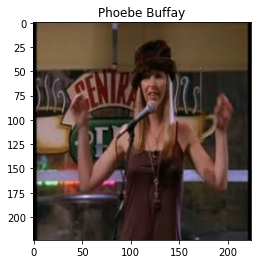

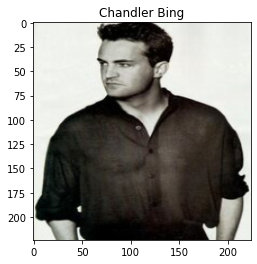

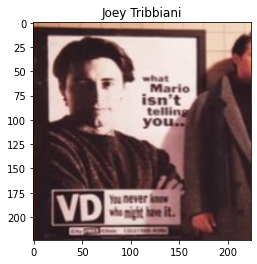

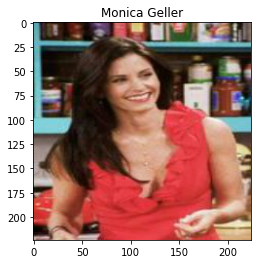

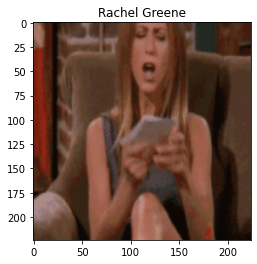

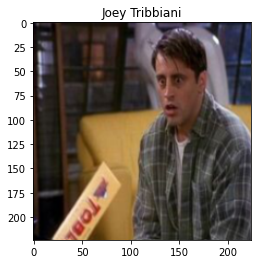

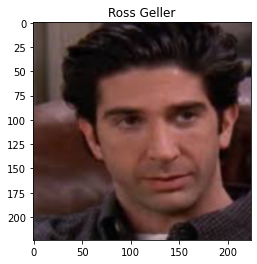

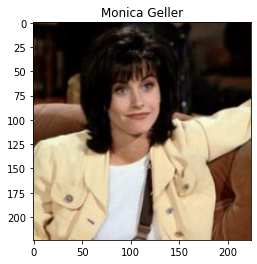

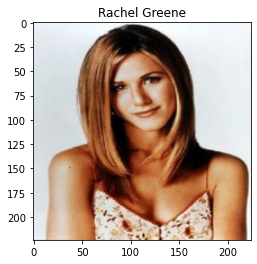

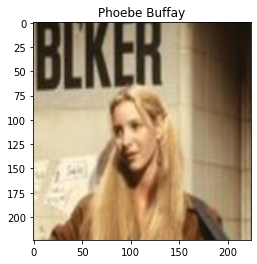

In [10]:
def show_input(input_tensor, mean, std, title=''):
    # transform to proper shape and make in numpy
    image = input_tensor.permute(1, 2, 0).numpy()
    # transform to proper constrast
    image = std * image + mean
    # show image
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class_names = [
    'Chandler Bing',
    'Joey Tribbiani',
    'Monica Geller',
    'Phoebe Buffay',
    'Rachel Greene',
    'Ross Geller'
]

# show train images
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, mean, std, title=class_names[y_item])

## Building Model

In [11]:
def train_model(model, data_loader, loss, optimizer, scheduler, num_epochs):
    loss_history = []
    acc_history = []
   
    
    for epoch in range(num_epochs):
        scheduler.step()
        model.train()
        
        running_loss = 0
        running_acc = 0
        
         
        for x, y in tqdm(data_loader):
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                preds = model(x)
                
                loss_value = loss(preds, y)
                loss_value.backward()
                preds_class = preds.argmax(dim = 1)
                
                optimizer.step()
                
            running_loss+=loss_value.item()
            running_acc+=(preds_class==y.data).float().mean()
        
          
        print('EPOCH - ', epoch)
            
        epoch_loss =  running_loss / len(data_loader)
        epoch_acc =  running_acc /  len(data_loader)

        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)
        print('Epoch loss -', epoch_loss)
        print('Epoch accuracy -', epoch_acc)

        
    return model, loss_history, acc_history

In [12]:
model = models.resnet18(pretrained=True)

# vacate grads
for param in model.parameters():
    param.requires_grad = False

# we have 6 classes
model.fc = torch.nn.Linear(model.fc.in_features, 6)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model, loss_history, acc_history \
    = train_model(model, train_dataloader, loss, optimizer, scheduler, 25)

  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  0
Epoch loss - 1.724036188920339
Epoch accuracy - tensor(0.2948)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  1
Epoch loss - 1.353294547398885
Epoch accuracy - tensor(0.5219)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  2
Epoch loss - 1.1486136138439178
Epoch accuracy - tensor(0.6043)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  3
Epoch loss - 1.000403090318044
Epoch accuracy - tensor(0.6938)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  4
Epoch loss - 0.824791423479716
Epoch accuracy - tensor(0.7852)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  5
Epoch loss - 0.8641026467084885
Epoch accuracy - tensor(0.8086)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  6
Epoch loss - 0.8034956226746242
Epoch accuracy - tensor(0.8367)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  7
Epoch loss - 0.8117926299571991
Epoch accuracy - tensor(0.8205)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  8
Epoch loss - 0.8258695145448048
Epoch accuracy - tensor(0.8057)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  9
Epoch loss - 0.8011676172415415
Epoch accuracy - tensor(0.8386)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  10
Epoch loss - 0.7925859967867533
Epoch accuracy - tensor(0.8567)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  11
Epoch loss - 0.8093906968832016
Epoch accuracy - tensor(0.8200)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  12
Epoch loss - 0.815444086988767
Epoch accuracy - tensor(0.8119)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  13
Epoch loss - 0.8009326597054799
Epoch accuracy - tensor(0.8105)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  14
Epoch loss - 0.8092237214247385
Epoch accuracy - tensor(0.8219)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  15
Epoch loss - 0.7383973459402721
Epoch accuracy - tensor(0.8486)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  16
Epoch loss - 0.782961231470108
Epoch accuracy - tensor(0.8176)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  17
Epoch loss - 0.7538006901741028
Epoch accuracy - tensor(0.8667)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  18
Epoch loss - 0.7941188146670659
Epoch accuracy - tensor(0.8371)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  19
Epoch loss - 0.7655908972024917
Epoch accuracy - tensor(0.8205)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  20
Epoch loss - 0.7456851859887441
Epoch accuracy - tensor(0.8600)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  21
Epoch loss - 0.8210897386074066
Epoch accuracy - tensor(0.8043)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  22
Epoch loss - 0.7994892706473669
Epoch accuracy - tensor(0.8271)


  0%|          | 0/30 [00:00<?, ?it/s]

EPOCH -  23
Epoch loss - 0.8075884083906809
Epoch accuracy - tensor(0.8186)


100%|██████████| 30/30 [00:14<00:00,  2.12it/s]

EPOCH -  24
Epoch loss - 0.8096301436424256
Epoch accuracy - tensor(0.8071)


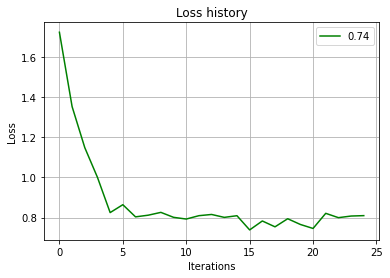

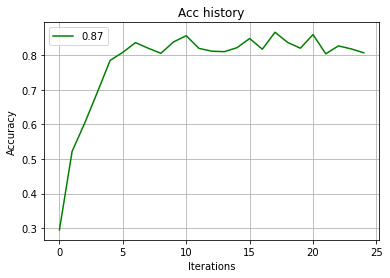

In [13]:
plt.plot(loss_history, label = round(min(loss_history), 2), color='g')
plt.title('Loss history')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.grid()
plt.show()

plt.plot(acc_history, label = round(max(acc_history).item(), 2), color = 'g')
plt.title('Acc history')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.grid()
plt.show()

In [14]:
# transforms test images
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
    
test_dataset = ImageFolder(test_directory, test_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=7, shuffle=False, num_workers=0)

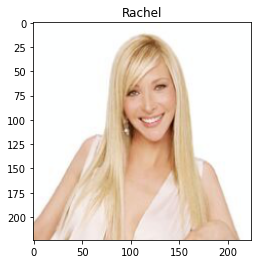

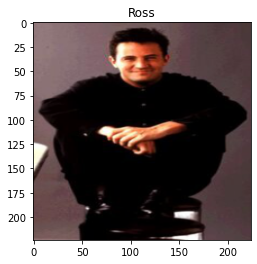

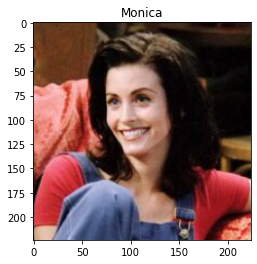

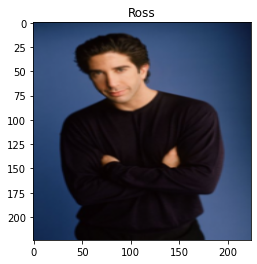

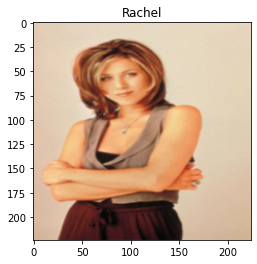

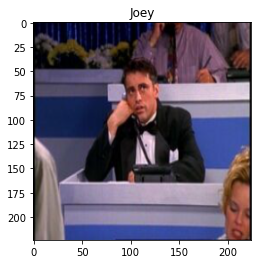

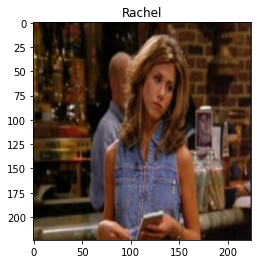

In [16]:
# make predictions
model.eval()

inputs, labels = next(iter(test_dataloader))

test_predictions = torch.nn.functional.softmax(model(inputs)).argmax(dim = 1)

dct = {value: key for key,value in train_dataset1.class_to_idx.items()}

# loook to result
for img, pred in zip(inputs, test_predictions):
    
    show_input(img, mean, std, title=dct[pred.item()])